# Expectation Maximisation on Mixture Model

# Table of contents
1. [Setting the ground truth](#first-bullet)
2. [Glossary of terms](#Glossary of terms)
2a. [The model](#The model)
2b. [Probabilities](#Probabilities)
2c. [Likelihood](#Likelihood)
2d. [Intermediate values](#Intermediate values)
3. [Generating samples from ground truth](#Generating samples from ground truth)
4. [Defining the negative log-likelihood](#Defining negative log-likelihood)
5. [EM algorithm](#EM algorithm) 
5a. [Expectation Step](#Expectation Step) 
5b. [Maximisation Step](#Maximisation Step)
6. [Performing iterations](#Performing iterations) 
6a. [Setting the initial parameters](#Setting the initial parameters)

In this notebook, we are demostrating an working example of Expectation Maximisation. We will generate a set of observations from a mixture bimodal Gaussian distribution with some chosen parameters. This samples is then assumed to be observed data, and the original parameters is unknown or lost. Then, we will find the best parameters for the observation with Expectation Maximisation.

We model $\phi$ as a mixture of two Gaussian distirbutions, with parameters $\theta = (p, \mu_1, \sigma_1, \mu_2, \sigma_2)$:

$$\begin{align}
\phi &= (1 - z) \cdot \phi_1 + z\cdot \phi_2 \\
\phi_1 &\sim N(\mu_1 , \sigma_1^2 ) \\
\phi_2 &\sim N(\mu_2 , \sigma_2^2 ) 
\end{align}$$

where $z = 0 \text{ or } 1$ and $P(z = 1) = p$

Following is the pdf of $\phi$:

$$\begin{align}
\phi(x \mid \theta) &= (1 - p) \cdot \phi_1(x\mid \mu_1, \sigma_1) 
+ p \cdot \phi_2(x \mid \mu_2, \sigma_2)\\
&= \frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x - \mu_2)^2} {2 \sigma_2^2}}\right) 
\end{align}$$

# Glossary of terms <a class="anchor" id="Glossary of terms"></a>


### The model <a class="anchor" id="The model"></a>

$\phi$ The pdf of the bimodal Mixture Guassian distribution. The model is defined with parameter $\theta$. <br\>
$\theta$ The parameter vector of model $Y$. $\theta$ is made up of parameters $\{p, \mu_1, \sigma_1, \mu_2, \sigma_2\}$

$p$ `pi` The probability of a sample being sampled from Gaussian distribution $\phi_2$ rather than $\phi_1$. <br\>
$z$ The hidden variable that indicates which Gaussian distribution a sample was from. <BR>
If $z = 0$, then the observation was sampled from $Y_1$. <BR>
If $z = 1$, then the observation was sampled from $Y_2$.

$\phi_1$ The first Gaussian distribution that makes up the mixture distribution. It is defined by parameters $\mu_1$ and $\sigma_1$ <br\>
$\mu_1$ `mu_1` The mean of Gaussian distribution $\phi_1$ <br\>
$\sigma_1$ `stde_1` The standard deviation of Gaussian distribution $\phi_1$

$\phi_2$ The second Gaussian distribution that makes up the mixture distribution. It is defined by of parameters $\mu_2$ and $\sigma_2$ <br\>
$\mu_2$ `mu_2` The mean of Gaussian distribution $\phi_2$ <br\>
$\sigma_2$ `stde_2` The standard deviation of Gaussian distribution $\phi_2$

$\phi$ The second Gaussian distributions that makes up the mixture distribution.

### Probabilities <a class="anchor" id="Probabilities"></a>

$\mathbf{X} = (x_1, x_2, \dots, x_N)$ `samples` The set of observations $x_i$ of length $N$ sampled from ground truth. <br\>
$\mathbf{Z} = (z_1, z_2, \dots, z_N)$ The set of hidden variables of length $N$ that corresponds to the "state" $z_i$ of the system at each observation $i$. <br\>

COMMENT: WHAT IS STATE?

COMMENT: How are we defining probability of obtaining a discrete variable from a continuous pdf? <BR> Shouldn't we be concerned with pdf instead?<br\>
SHOULD WE NOT USE THIS INSTEAD? 
 
$P(x)$ Probability of event $x$ happening. <br\>

$P(\mathbf{X} \mid  \theta)$ Conditional probability of getting observations $\mathbf{X}$ given the parameters of the model $\theta$.

$P(\mathbf{X} \mid  \mathbf{Z}, \theta)$ Conditional probability of getting observations $\mathbf{X}$ given the hidden variables $\mathbf{Z}$ and parameters of the model $\theta$

$P(\mathbf{X}, \mathbf{Z} \mid \theta)$ Conditional probability of getting both observations $\mathbf{X}$ and hidden variables $\mathbf{Z}$ given the parameters of the model $\theta$

### Likelihood <a class="anchor" id="Likelihood"></a>

$\ell(x \mid y)$ The log-likelihood of y given x. $\ell(x \mid y) = -\log P(y \mid x)$

$\ell(\theta \mid  \mathbf{X})$ `calc_nll` The log-likelihood of parameter $\theta$ given observations $\mathbf{X}$

$\ell(\theta \mid  \mathbf{X}, \mathbf{Z})$ The log-likelihood of parameter $\theta$ given observations $\mathbf{X}$ and hidden variables $\mathbf{Z}$. 

$\ell(\theta, \mathbf{Z} \mid \mathbf{X})$ The log-likelihood of parameter $\theta$ and hidden variables $\mathbf{Z}$ given observations $\mathbf{X}$.

### Intermediate values  <a class="anchor" id="Intermediate values"></a>


TODO: MOVE TO LATER: $\gamma$ The responsibility of one of the two Gaussians on a sample, given current model $\theta$.  "PROPORTION"

$\gamma_i$ `gamma_i` is the probability that the sample $i$ belongs to $\theta_2$ rather than $\theta_1$, given $\theta$ and $\mathbf{X}$

$\gamma_i = \mathbb{E}(z_i \,  \mid  \, \theta, \mathbf{X}) = P(z_i = 1 \,  \mid  \, \theta, x_i)$

COMMENT: WHY BOLD X?

# Setting the ground truth <a class="anchor" id="first-bullet"></a>

This is the ground truth parameter vector 
<br> $\theta_{true} = (p, \mu_1, \sigma_1, \mu_2, \sigma_2) = $ `pi_true, stde_1_true, mu_2_true, stde_2_true`  

This is used to generate the set of samples.

In [1]:
pi_true = 0.8  # probability if it lies from normal distribution 2 
mean_1_true = 1.
stde_1_true = 1.0
mean_2_true = 4.
stde_2_true = 0.8

We will show pdfs $\phi$ as well as $\phi_1$ and $\phi_2$.

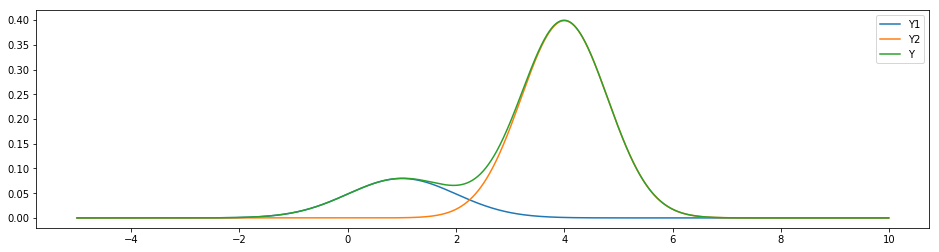

In [11]:
import numpy as np
import matplotlib.pyplot as plt

plot_range = np.arange(-5,10,0.01)
pdf_Y1 = [((1.-pi_true)/(np.sqrt(2.*np.pi*stde_1_true**2.))) * 
          np.exp(-(x - mean_1_true)**2. / (2.*stde_1_true**2)) for x in plot_range]
pdf_Y2 = [(pi_true/(np.sqrt(2.*np.pi*stde_2_true**2.))) * 
          np.exp(-(x - mean_2_true)**2. / (2.*stde_2_true**2)) for x in plot_range]
pdf_Y = np.add(pdf_Y1,pdf_Y2)

plt.figure(figsize=(16,4))
plt.plot(plot_range, pdf_Y1, label="Y1")
plt.plot(plot_range, pdf_Y2, label="Y2")
plt.plot(plot_range, pdf_Y, label="Y")
plt.legend(loc="best")
plt.show()

# Generating samples from the ground truth <a class="anchor" id="Generating samples from ground truth"></a>

We will now generate some samples from $\theta_{true}$, and this will be $\mathbf{X}$

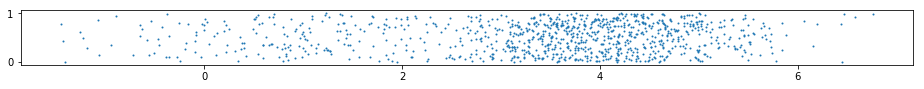

In [16]:
l = 1000
dot_size = 1.

samples = [stde_1_true*np.random.randn() + mean_1_true
           if np.random.random() > pi_true 
           else stde_2_true*np.random.randn() + mean_2_true
           for _ in range(l)]

plt.figure(figsize=(16,1))
plt.scatter(samples,np.random.random(l),s=dot_size)
plt.show()

We now plot the histogram of observations $\mathbf{X}$, and compare with the $\phi$.

In [17]:
def plot_hist_pdf(samples_, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    plt.figure(figsize=(16,2))
    pdf_Y1 = [((1.-pi_)/(np.sqrt(2.*np.pi*stde_1_**2.))) * 
            np.exp(-(x - mean_1_)**2. / (2.*stde_1_**2)) for x in plot_range]
    pdf_Y2 = [(pi_/(np.sqrt(2.*np.pi*stde_2_**2.))) * 
            np.exp(-(x - mean_2_)**2. / (2.*stde_2_**2)) for x in plot_range]
    pdf_Y = np.add(pdf_Y1,pdf_Y2)
    plt.hist(samples, normed=True, bins=plot_range, color="orange")
    plt.plot(plot_range,pdf_Y1, label="Y1")
    plt.plot(plot_range,pdf_Y2, label="Y2")
    plt.plot(plot_range,pdf_Y, label="Y")
    plt.show()
    print("pi = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(pi_,mean_1_,mean_2_,stde_1_,stde_2_))
    
# making histograms take time
# https://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
# but this doesn't seem to be faster

/anaconda3/envs/nus/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


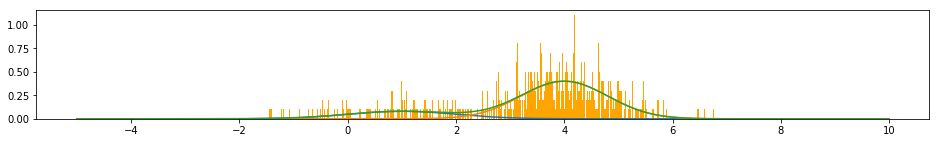

pi = 0.8000, mean_1 = 1.0000, mean_2 = 4.0000, stde_1 = 1.0000, stde_2 = 0.8000


In [18]:
plot_hist_pdf(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

# Defining the log-likelihood <a class="anchor" id="Defining negative log-likelihood"></a>

We want to maximise the likelihood w.r.t. parameter vector $\theta = \{p , \mu_1, \sigma_1, \mu_2, \sigma_2\}$ given observations $\mathbf{X}$, ie $(x_1, x_2,....., x_n)$.


$$P(\mathbf{X}  \mid  \theta) =\prod_i \left[ 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right] $$

As product of likelihoods is too small for calculations, it is better if we maximize the log likelihood instead:

$$\begin{align}
\ell(\theta  \mid  \mathbf{X}) &= \log P(\mathbf{X}  \mid  \theta) \\
&= \sum_i log\left[ 
\frac{1-p}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)
+ \frac{p}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right] \\
&= \sum_i log\left( 
(1-p)\phi_1 (x_i)
+ (p)\phi_2 (x_i)\right)
\end{align}$$

The evaluation of $\ell (\theta \mid \mathbf{X})$ is specified in function `calc_nll`

TODO: CHANGE ALL NEGATIVE LOG LIKELIHOOD TO LOG LIKELIHOOD - WE WANT TO MAXIMISE

In [28]:
def calc_nll(samples, pi_, mean_1_, mean_2_, stde_1_, stde_2_):
    l_ = len(samples)
    return -np.sum(
            np.log(
                (1-pi_)/(stde_1_*np.sqrt(2*np.pi))
                  *np.exp(-np.power(np.add(samples,[-mean_1_]*l_),2))/(2*stde_1_**2)
                + (pi_/(stde_2_*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(samples,[-mean_2_]*l_),2))/(2*stde_2_**2)))

We now calculate log-likelihood w.r.t. ground truth $\theta_{true}$ `nll_true` for future reference.

In [29]:
nll_true = calc_nll(samples, pi_true, mean_1_true, mean_2_true, stde_1_true, stde_2_true)

print("nll_true = {}".format(nll_true))

nll_true = 2231.5375199407276


# EM algorithm <a class="anchor" id="EM algorithm"></a>

## General Overview
The direct maximisation of $\ell(\theta,\mathbf{X})$ is made difficult because of the sum of terms inside the logarithm. Therefore we define a function $\ell ( \theta \mid  \mathbf{X}, \mathbf{Z})$ that is equal at $\theta = \theta_0$ but lower than $\ell(\theta \mid \mathbf{X})$ everywhere else. 


TODO: BORROW A PICTURE WITH REFERENCE

The interpretation of the $\mathbf{Z}$ is a vector of hidden variables taking values 0 or 1 that guesses which of distributions $\phi_1$ or $\phi_2$ each sample $x$ comes from. If $z_i = 0$ then that sample $i$ comes from $\phi_1$, if $z_i = 1$ then that sample $i$ comes from $\phi_2$.

If we are given a vector $\mathbf{Z}$ of hidden variables $( z_1, z_2, \dots, z_n )$ that are binary values of 1 or 0, the expression becomes:

$$\begin{align}
\ell(\theta, \mathbf{Z}  \mid  \mathbf{X}) &= \log P(\mathbf{X}  \mid  \theta, \mathbf{Z}) \\ 
&= \sum_i log \phi(x_i) \cdot \chi_{z_i=0} + \sum_j log \phi(x_j) \cdot \chi_{z_j=1} \\
&= \sum_i log\left( 
\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) 
\right)
\end{align}$$

TODO: REMOVE Practically speaking, this then becomes the addition of the log likelihoods of exactly two different distributions, as we now are guessing exactly which distribution each sample comes from.

In [25]:
## we have arbitrary starting points which we will elaborate later
pi, mean_1, stde_1, mean_2, stde_2 = 0.8, 2.1, 1.1, 4.1, 3.81

## Expectation Step <a class="anchor" id="Expectation Step"></a>

COMMENT: "RESPONSIBILITY"

Interpretation for responsibility $\gamma_i$: given current model $\theta$, $\gamma_i$ is the probability that the sample belongs to $\phi_2$ rather than $\phi_1$. It can also be interpreted as an approximation for $z$, as the closer $\gamma_i$ is to 1, the more likely $z$ is 1.

$$\gamma_i(\theta) = E\left(z_i  \mid  \theta, \mathbf{X}\right) = P\left(z_i = 1  \mid  \theta, \mathbf{X}\right) $$

$$ \gamma_i(\theta) = \frac{p \phi_{2} (x_i)} 
{(1 - p) \phi_{1} ( x_i ) + p \phi_{2} ( x_i )} $$

In [30]:
def expectation_step(pi,mean_1,mean_2,stde_1,stde_2,samples):
    odds_Y1 = [((1-pi)/(stde_1*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_1)**2. / (2. * stde_1**2)) for x in samples]
    odds_Y2 = [((pi)/(stde_2*np.sqrt(2*np.pi))) 
                * np.exp(-(x - mean_2)**2. / (2. * stde_2**2)) for x in samples]
    gamma_i = np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))
    return gamma_i

gamma_i = expectation_step(pi,mean_1,mean_2,stde_1,stde_2,samples)
print(np.round(gamma_i[:30],3))  # the gamma values of some of the samples

[0.84  0.754 0.669 0.779 0.65  0.819 0.865 0.712 0.649 0.882 0.82  0.809
 0.653 0.896 0.864 0.863 0.784 0.757 0.81  0.95  0.697 0.838 0.649 0.839
 0.649 0.776 0.908 0.828 0.697 0.779]


### Insertion of Hidden Variables
We first observe that we can insert the hidden variables $z$ through the law of total probability.

$$
\begin{align} 
\log P(\mathbf{X}  \mid  \theta) &= \sum_i log P(x_i \mid  \theta)   \\
&= \sum_i log\left(\sum_z P(x_i \mid z,\theta)P(z \mid \theta)\right) \\
&= \sum_i log\left( P(x_i \mid z =0,\theta)P(z=0 \mid \theta) + P(x_i \mid z =1,\theta)P(z=1 \mid \theta)\right)\\
\end{align}$$


This corresponds to
$$
\begin{align} 
\log P(\mathbf{X}  \mid  \theta) &= \sum_i log\left( \sum_z \left(
\frac{1- z}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{z}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) \right) \cdot P(z \mid \theta)
\right) \\
&= \sum_i log\left( \left(
\frac{1- 0}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)\cdot P(z=0) \right) \right. \\ 
&\qquad \qquad + \left. \left(\frac{1}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right) \cdot P(z=1) \right)
\right) \\ 
&= \sum_i log\left( 
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right) \\
&= \sum_i log\left( 
(1-p)\phi_1 (x_i)
+ (p)\phi_2 (x_i)\right)
\end{align}
$$

% I don't know if '\{multiline}' work in LaTeX.
% I think we need to use different types of parentheses.
% This is markdown not LaTeX, so these comments are still visible

This simplification shows us that the insertion of the hidden variables stil makes the expression mathematically equal to our $\log P(\mathbf{X}  \mid  \theta)$ expression at first.

### Derivation of $log P(\mathbf{X}  \mid  \mathbf{Z}, \theta)$

The form of $log P(\mathbf{X},\mathbf{Z}  \mid  \theta)$ is required in the Expectation step. It has been derived in the EM tutorial (and will be derived later) and is needed to find the next iteration of $\theta$. Hence, we want to find the form of $log P(\mathbf{X},\mathbf{Z}  \mid  \theta)$.

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z}  \mid  \theta) &= \sum_i log P(x_i, z_i \mid  \theta)   \\
&= \sum_i log\left( P(x_i \mid z_i,\theta)P(z_i \mid \theta)\right) \\
\end{align}$$

We observe that $P(z_i \mid \theta)$ refers to simply $(1-p)$ when $p=0$ or $p$ when $p = 1$. 

$$
\begin{align} 
\log P(\mathbf{X} ,\mathbf{Z} \mid  \theta) &= \sum_i log \left(
\left(\frac{1- z_i}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right)\cdot (1-p)\right) 
+ \left(\frac{z_i}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)\cdot(p)\right)
\right) \\
&= \sum_i log\left( 
\frac{(1- z_i)(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) 
+ \frac{(z_i)(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)
\right)\\
&= \sum_i \left( (1- z_i)log\left(
\frac{(1-p)}{\sigma_1\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_1)^2} {2 \sigma_1^2}}\right) \right)
+ (z_i)log\left(\frac{(p)}{\sigma_2\sqrt{2 \pi}} exp\left({-\frac{(x_i - \mu_2)^2} {2 \sigma_2^2}}\right)\right)
\right) \\
&= \sum_i (1-z_i)log\left( 
(1-p)\phi_1 (x_i)\right)
+ (z_i)log\left( (p)\phi_2 (x_i)\right)
\end{align}$$

The second last step, which involves taking the indicator variables $(1- z_i)$ or $(z_i)$ outside the logarithm terms, holds as the expansion of the terms are equal. i.e $ log(0\cdot x + y) = 0\cdot log(x) + log(y)$

## Maximisation Step <a class="anchor" id="Maximisation Step"></a>
From the tutorial, at the nth iteration with estimated parameters $\theta_{n}$, we can find the n+1 iteration of parameters $\theta_{n+1}$ through maximizing $\sum_{i=1}^N P(z_i \mid x_i,\theta_n)log P(x_i, z_i \mid \theta)$ with respect to $\theta$, proven through Jensen's Inequality.


### Deriving $\theta_{n+1}$

From the EM tutorial, we see a way of iteration is to find a $\theta_{n+1}$ with respect to $\theta$ such that:

$$
\begin{align} 
\theta_{n+1} = argmax \left(\sum_i P(z_i \mid x_i, \theta_n)\cdot log P(x_i,z_i  \mid \theta) \right) \\
\end{align}$$

The expression for $log P(x,z  \mid \theta)$ has been found above. We can think of $P(z \mid X, \theta_n)$ as the responsibility, $\gamma$. 

Interpretation for $\gamma_i$: given current model $\theta_n$, $\gamma_i$ is the probability that the $i$th sample belongs to $Y_2$ rather than $Y_1$. In Pattern Theory, ${\gamma}_i$ is analgous to $L_i$.

$$\gamma_i(\theta_n) =\gamma_{i,n} = E\left(z_i  \mid  \theta_n, \mathbf{X}\right) = P\left(z_i = 1  \mid  \theta_n, \mathbf{X}\right) $$

$$ \gamma_{i,n} = \frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} $$

Combining both the expressions we have found above and the responsibilities, we get:

$$
\begin{align} 
\theta_{n+1} 
&= argmax \left(\sum_i P(z_i \mid x_i,\theta_n)\cdot log P(x_i, z_i \mid \theta)\right) \\
&= argmax \left(\sum_i P(z_i = 0 \mid x_i,\theta_n) \cdot log P(x_i \mid \theta, z_i =0) +  P(z_i = 1 \mid x_i,\theta_n)\cdot log P(x_i \mid \theta, z_i =1) \right) \\
&= argmax \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) \\
&= argmax \left(\sum_i \frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} \cdot log(p \cdot \phi_{2}(x_i)) 
+ \left(1 -\frac{p_n \phi_{2,n} ( x_i )}{(1 - p_n) \phi_{1,n} ( x_i ) + p_n \phi_{2,n} ( x_i )} \right) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) \\
\end{align}$$



## Solutions for $\theta_{n+1}$
To find $\theta_{n+1}$, we set $\frac{\partial}{\partial \theta} \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right)=0$

We first find the expression of $\mu_{2,n+1}$, which is the $\mu_2$ that fulfills the equation above.
$$
\begin{align}
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) &=0 \\
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) \right)&=0 \\
\frac{\partial}{\partial \mu_{2}} \left(\sum_i \gamma_{i,n} \cdot log(\frac{p_n}{\sigma_{2,n} \sqrt{2 \pi}} \cdot exp \left( -\frac{(x_i - \mu_{2})^2} {2 \sigma_{2,n}^2} \right)) \right)&=0 \\
\sum_i \gamma_{i,n} \cdot \frac{x_i - \mu_2}{\sigma_{2,n}^2} &=0 \\
\mu_2 = \frac{\sum_i \gamma_{i,n} \cdot x_i}{\sum_i \gamma_{i,n}}   \\
\end{align}$$

We then find $\sigma_{2,n+1}$.
$$
\begin{align}
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p_n) \cdot \phi_{1}(x_i)) \right) &=0 \\
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log(p_n \cdot \phi_{2}(x_i)) \right)&=0 \\
\frac{\partial}{\partial \sigma_{2}} \left(\sum_i \gamma_{i,n} \cdot log(\frac{p_n}{\sigma_{2} \sqrt{2 \pi}} \cdot exp ( -\frac{(x_i - \mu_{2,n})^2} {2 \sigma_{2}^2} ) \right)&=0 \\
\sum_i \gamma_{i,n} \cdot \left(-\frac{1}{\sigma_2} +\frac{(x_i-\mu_{2,n})^2}{\sigma_{2}^3}  \right) &=0 \\
\sum_i \gamma_{i,n} \cdot \left(\frac{(x_i-\mu_{2,n})^2-\sigma_{2}^2}{\sigma_{2}^3}  \right) &=0 \\
\sum_i \gamma_{i,n} \cdot (x_i-\mu_{2,n})^2 &= \sum_i \gamma_{i,n} \cdot \sigma_{2}^2 \\
\sigma_{2} &= \frac{\sum_{i=1} \gamma_{i,n} (x_i - \mu_{2,n})^2}{\sum_{i=1} \gamma_{i,n}}  \\
\end{align}$$

We then find $p_{n+1}$.
$$
\begin{align}
\frac{\partial}{\partial p} \left(\sum_i \gamma_{i,n} \cdot log(p \cdot \phi_{2}(x_i)) + (1 -\gamma_{i,n}) \cdot log((1-p) \cdot \phi_{1}(x_i)) \right) &=0 \\
\sum_i \gamma_{i,n} \left(\frac{\sigma_{2,n} \sqrt{2 \pi}}{p} \cdot \frac{1}{\sigma_{2,n} \sqrt{2 \pi}}   \right) + (1- \gamma_{i,n}) \left(\frac{\sigma_{1,n} \sqrt{2 \pi}}{1-p} \cdot \frac{-1}{\sigma_{1,n} \sqrt{2 \pi}}   \right) &=0 \\
\sum_i \frac{\gamma_{i,n}}{p} + \frac{1- \gamma_{i,n}}{p-1} &=0 \\
\sum_i \frac{\gamma_{i,n} \cdot (p-1) + (1 - \gamma_{i,n}) \cdot (p)}{(p)(p-1)} &=0 \\
\sum_i \frac{p - \gamma_{i,n}}{(p)(p-1)} &=0 \\
\sum_i p &= \sum_i \gamma_{i,n}\\
p &= \frac{\sum_i \gamma_{i,n}}{N}\\
\end{align}$$



## Summary of Solutions for $\theta_{n+1}$
$$\begin{align}
p_{n+1}&= \frac{
\sum_{i=1}^N \gamma_{i,n}
}{
N
} \\
\mu_{1,n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) x_i
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} \\
\sigma_{1, n+1} &= \frac{
\sum_{i=1}^N (1 - \gamma_{i,n}) (x_i - \mu_{2,n})^2
}{
\sum_{i=1}^N (1 - \gamma_{i,n})
} \\
\mu_{2,n+1} &= \frac{
\sum_{i=1}^N \gamma_{i,n} x_i
}{
\sum_{i=1}^N \gamma_{i,n}
} \\
\sigma_{2, n+1} &= \frac{
\sum_{i=1}^N \gamma_{i,n} (x_i - \mu_{2,n})^2
}{
\sum_{i=1}^N \gamma_{i,n}
} 
\end{align}$$


In [27]:
def maximisation_step(gamma_i, samples):
    gamma_1_i = 1 - gamma_i
    pi = np.sum(gamma_i)/l
    mean_1 = np.sum(np.multiply(gamma_1_i,samples)) / np.sum(gamma_1_i)
    mean_2 = np.sum(np.multiply(gamma_i,samples)) / np.sum(gamma_i)
    stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
                            np.power(np.add(samples,[-mean_1]*l),2)))/np.sum(gamma_1_i))
    stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
                            np.power(np.add(samples,[-mean_2]*l),2)))/np.sum(gamma_i))
    return pi, mean_1, mean_2, stde_1, stde_2

pi, mean_1, mean_2, stde_1, stde_2 = maximisation_step(gamma_i, samples)
print("pi = {:.4f}, mean_1 = {:.4f}, mean_2 = {:.4f}, stde_1 = {:.4f}, stde_2 = {:.4f}"
      .format(pi,mean_1,mean_2,stde_1,stde_2))
# note how the values are being updated

pi = 0.7797, mean_1 = 2.7420, mean_2 = 3.5912, stde_1 = 1.2260, stde_2 = 1.5319


# Performing iterations <a class="anchor" id="Performing iterations"></a>
We will do many iterations, and see their result.

## Setting the initial parameters <a class="anchor" id="Setting the initial parameters"></a>
We will need to start from a set of parameters to begin our parameters from. Perhaps we should use something that is reasonable. The initial mean for each of the distribution value should be slightly different from one another so they can start diverging.

$$\begin{align}
\hat{\mu}_1 &= +\epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_1 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\mu}_2 &= - \epsilon + \frac{1}{N} \sum_{i=1}^N x_i \\
\hat{\sigma}_2 &= \sqrt{\frac{1}{N-1} \sum_{i=1}^N  (x_i - \hat{\mu}_2)^2} \\
\hat{\pi} &= 0.5 
\end{align}$$

In [10]:
# the five parameters
pi = 0.5  # probability if it lies from 
mean_1 = np.mean(samples) - np.std(samples)
stde_1 = np.std(samples) 
mean_2 = np.mean(samples) + np.std(samples)
stde_2 = np.std(samples)

In [11]:
pi_list = [pi]
mean_1_list = [mean_1]
stde_1_list = [stde_1]
mean_2_list = [mean_2]
stde_2_list = [stde_2]
nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
nll_list = [nll]

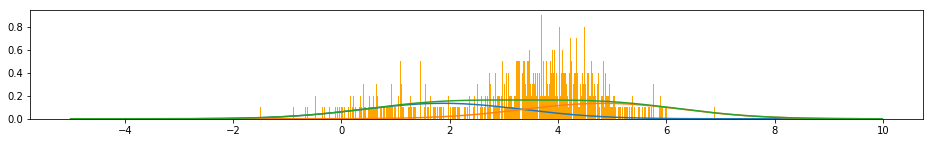

pi = 0.5000, mean_1 = 1.8761, mean_2 = 4.8355, stde_1 = 1.4797, stde_2 = 1.4797
interation 0, nll = 4392.492841325925


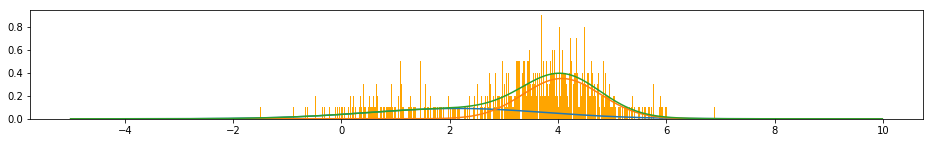

pi = 0.6300, mean_1 = 2.1403, mean_2 = 4.0697, stde_1 = 1.6418, stde_2 = 0.7177
interation 10, nll = 2610.88438764455


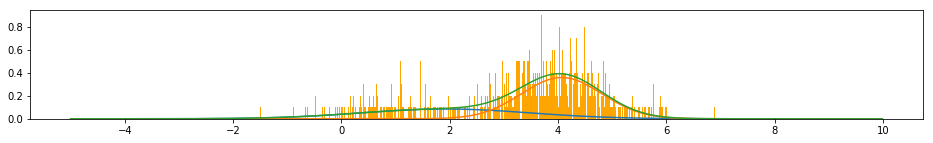

pi = 0.6679, mean_1 = 1.9223, mean_2 = 4.0685, stde_1 = 1.5518, stde_2 = 0.7426
interation 20, nll = 2537.0582040986556


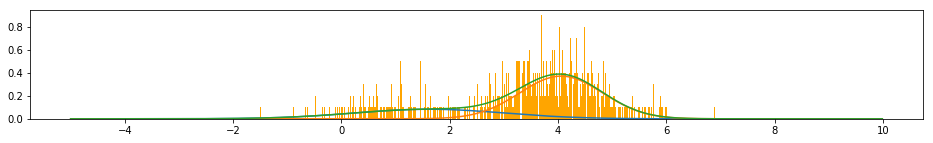

pi = 0.7117, mean_1 = 1.6202, mean_2 = 4.0587, stde_1 = 1.3848, stde_2 = 0.7653
interation 30, nll = 2413.325656234467


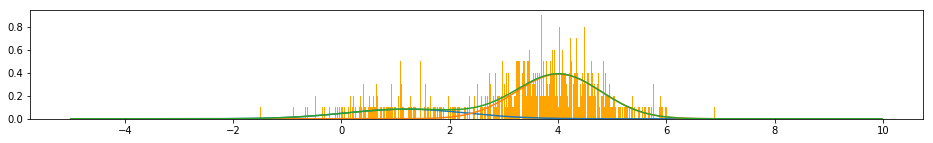

pi = 0.7673, mean_1 = 1.1856, mean_2 = 4.0139, stde_1 = 1.1068, stde_2 = 0.7880
interation 40, nll = 2238.6717819580635


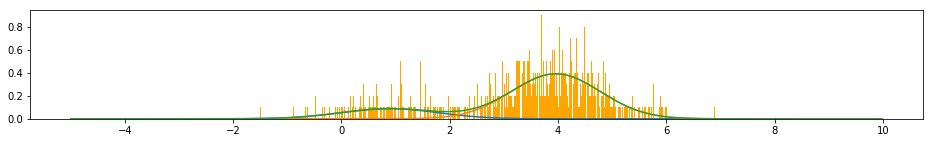

pi = 0.8027, mean_1 = 0.8897, mean_2 = 3.9618, stde_1 = 0.8908, stde_2 = 0.8191
interation 50, nll = 2177.091807493005


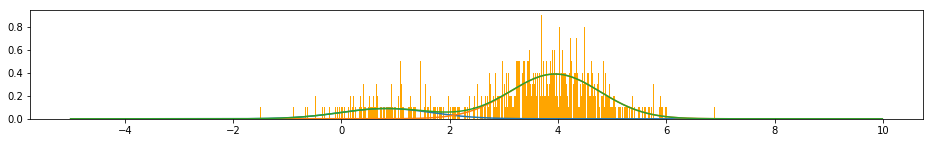

pi = 0.8107, mean_1 = 0.8257, mean_2 = 3.9467, stde_1 = 0.8439, stde_2 = 0.8310
interation 60, nll = 2180.1022692245538


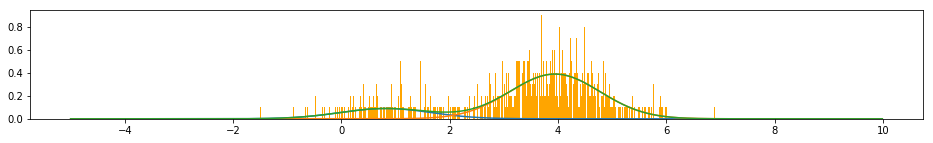

pi = 0.8116, mean_1 = 0.8183, mean_2 = 3.9448, stde_1 = 0.8386, stde_2 = 0.8326
interation 70, nll = 2181.1723038704695


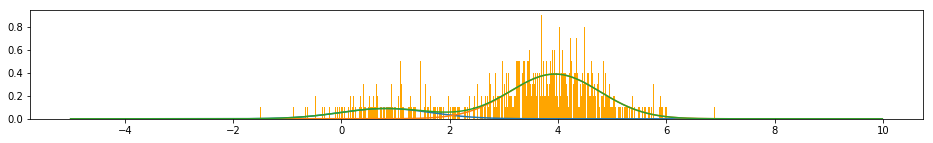

pi = 0.8117, mean_1 = 0.8176, mean_2 = 3.9446, stde_1 = 0.8381, stde_2 = 0.8327
interation 80, nll = 2181.2941544294317


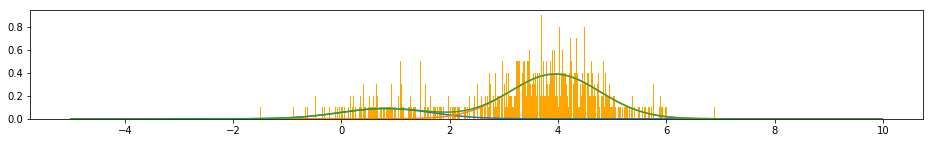

pi = 0.8117, mean_1 = 0.8175, mean_2 = 3.9446, stde_1 = 0.8380, stde_2 = 0.8328
interation 90, nll = 2181.3068633851562


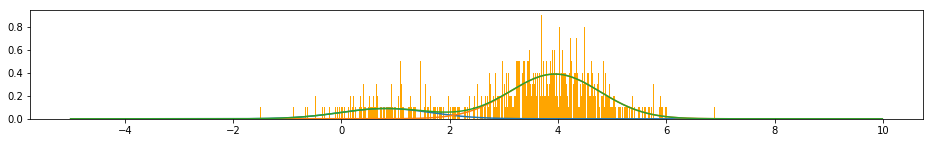

pi = 0.8117, mean_1 = 0.8175, mean_2 = 3.9446, stde_1 = 0.8380, stde_2 = 0.8328
interation 100, nll = 2181.3081771742095


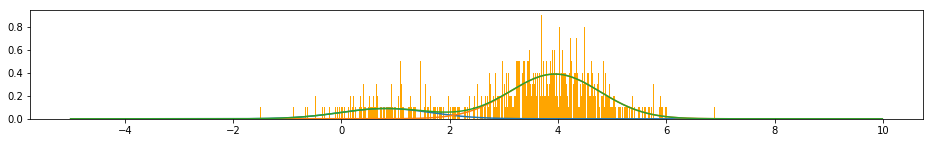

pi = 0.8117, mean_1 = 0.8175, mean_2 = 3.9446, stde_1 = 0.8380, stde_2 = 0.8328
interation 110, nll = 2181.308312862652


In [12]:
iterations = 120
plotting = False
for x in range(iterations):
    
    if x%10 == 0:
        plot_hist_pdf(samples, pi, mean_1, mean_2, stde_1, stde_2)
        print("interation {}, nll = {}".format(x, nll))
    
    gamma_i = expectation_step(pi,mean_1,mean_2,stde_1,stde_2,samples)
#     odds_Y1 = [((1-pi)/(stde_1*np.sqrt(2*np.pi))) 
#                 * np.exp(-(x - mean_1)**2. / (2. * stde_1**2)) for x in samples]
#     odds_Y2 = [((pi)/(stde_2*np.sqrt(2*np.pi))) 
#                 * np.exp(-(x - mean_2)**2. / (2. * stde_2**2)) for x in samples]
#     gamma_i = np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))
#     gamma_1_i = 1 - gamma_i
#     gamma_1_i = np.divide(odds_Y1,np.add(odds_Y1,odds_Y2))
    
#     pi = np.sum(gamma_i)/l
#     mean_1 = np.sum(np.multiply(gamma_1_i,samples)) / np.sum(gamma_1_i)
#     mean_2 = np.sum(np.multiply(gamma_i,samples)) / np.sum(gamma_i)
#     stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
#                             np.power(np.add(samples,[-mean_1]*l),2)))/np.sum(gamma_1_i))
#     stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
#                             np.power(np.add(samples,[-mean_2]*l),2)))/np.sum(gamma_i))
    
    pi, mean_1, mean_2, stde_1, stde_2 = maximisation_step(gamma_i, samples)
    
    pi_list.append(pi)
    mean_1_list.append(mean_1)
    stde_1_list.append(stde_1)
    mean_2_list.append(mean_2)
    stde_2_list.append(stde_2)
    nll = calc_nll(samples, pi, mean_1, mean_2, stde_1, stde_2)
    nll_list.append(nll)

### Statistics on the rate of decrease of nll

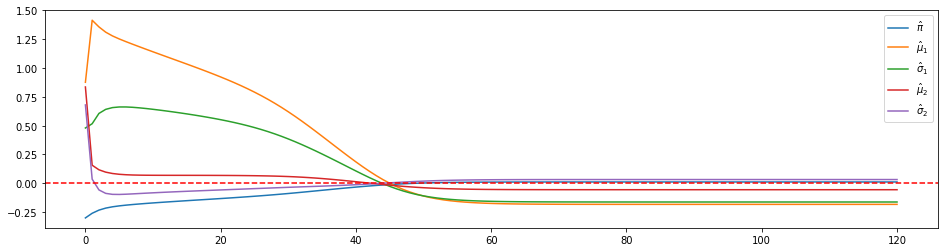

In [13]:
plt.figure(figsize=(16,4))
plt.plot(np.add(pi_list,-pi_true), label="$\hat{\pi}$")
plt.plot(np.add(mean_1_list,-mean_1_true), label="$\hat{\mu}_1$")
plt.plot(np.add(stde_1_list,-stde_1_true), label="$\hat{\sigma}_1$")
plt.plot(np.add(mean_2_list,-mean_2_true), label="$\hat{\mu}_2$")
plt.plot(np.add(stde_2_list,-stde_2_true), label="$\hat{\sigma}_2$")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc="best")
plt.show()

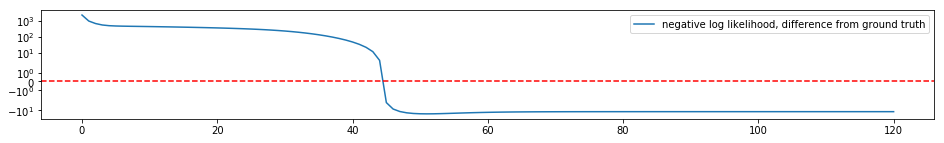

In [14]:
plt.figure(figsize=(16,2))
plt.plot(nll_list-nll_true, label="negative log likelihood, difference from ground truth")
plt.legend(loc="best")
plt.yscale('symlog')  # linear when near zero
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

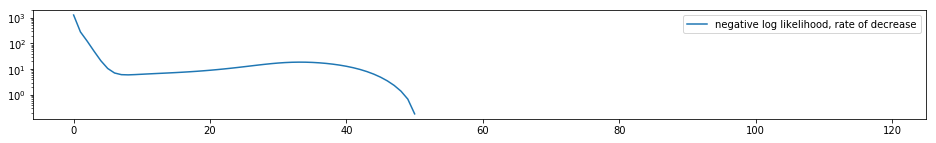

In [15]:
plt.figure(figsize=(16,2))
plt.plot(-np.diff(nll_list), 
             label="negative log likelihood, rate of decrease")
plt.legend(loc="best")
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()